Raw shape: (39644, 61)
Columns sample: ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs']
Data Head:
                                                  url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0  

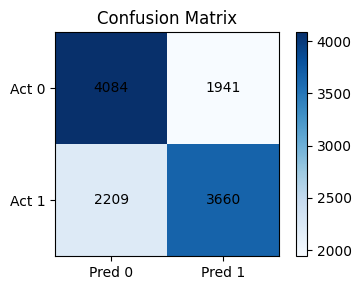

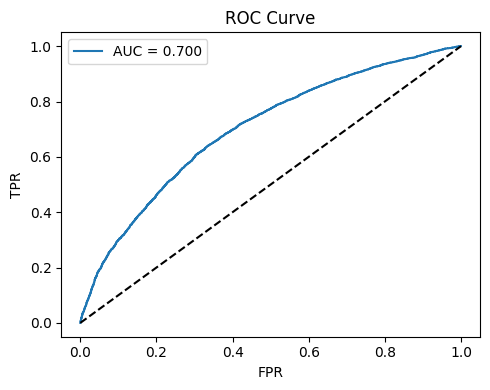

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# load and clean column names
fp = "OnlineNewsPopularity.csv"
df = pd.read_csv(fp)
df.columns = df.columns.str.strip()

# quick checks
print("Raw shape:", df.shape)
print("Columns sample:", df.columns[:8].tolist())

# === DATA HEAD & SHAPE ===
print("Data Head:\n", df.head())
print("\nShape of DataFrame:", df.shape)

# create binary target y (ensure shares exists)
if "shares" not in df.columns:
    raise RuntimeError("Column 'shares' not found after stripping names.")
y = (df["shares"].astype(float) > df["shares"].median()).astype(int)

# prepare X (drop url and shares if present), coerce numeric, fill medians
drop_cols = [c for c in ["url","shares"] if c in df.columns]
X = df.drop(columns=drop_cols).apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

# ensure same index alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# show compact heads and shapes
print("\nFeatures head (after preprocess):")
print(X.head())
print("\nTarget head:")
print(y.head())
print("\nShape of X and y:", X.shape, y.shape)
print("Class distribution:\n", y.value_counts(normalize=False))

# train/test split, scale, train logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# metrics
print("\nAccuracy :", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("Recall   :", round(recall_score(y_test, y_pred),4))
print("F1 Score :", round(f1_score(y_test, y_pred),4))

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC :", round(roc_auc,6))

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix"); plt.colorbar()
plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["Act 0","Act 1"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout(); plt.show()

# ROC curve plot
plt.figure(figsize=(5,4))
plt.plot(fpr,tpr,label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.tight_layout(); plt.show()


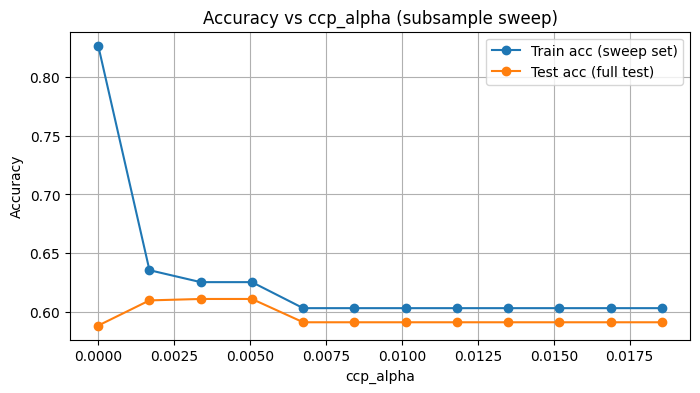

Chosen best_alpha: 0.0033740423405891644  test acc: 0.6108  train acc(sweep): 0.6252

Final Pruned Tree Metrics:
Train acc (full): 0.6178
Test  acc: 0.6122
Confusion matrix:
 [[3007 2014]
 [1829 3061]]
AUC: 0.639


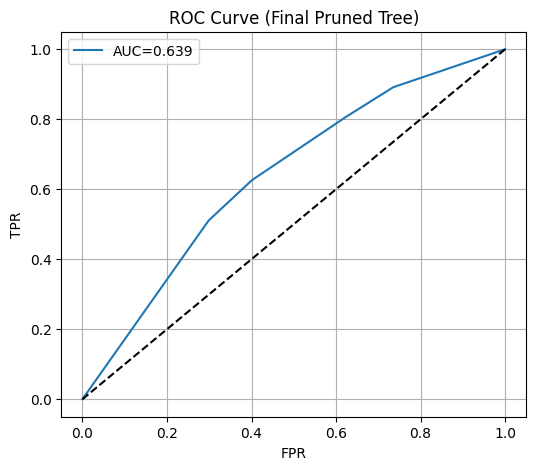

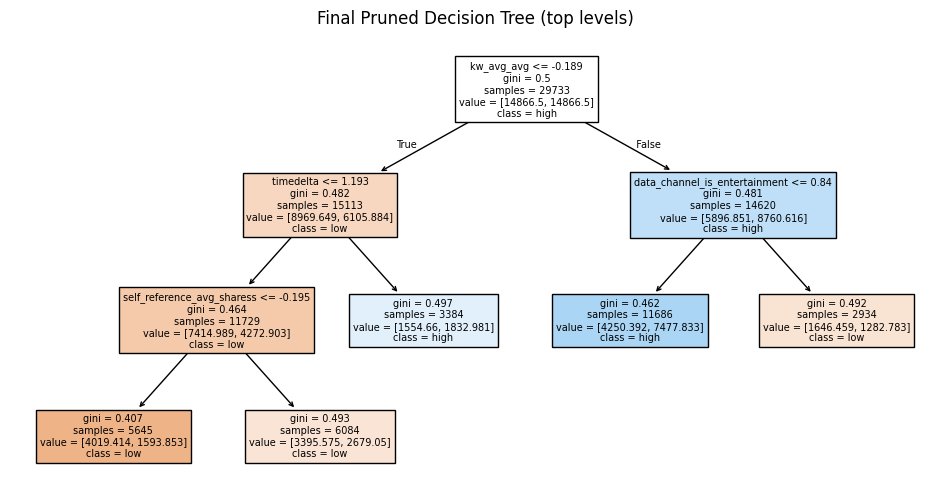

In [23]:
# Fast alpha-sweep + final pruned Decision Tree (uses /mnt/data/OnlineNewsPopularity.csv)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

fp = "OnlineNewsPopularity.csv"   # your uploaded file
df = pd.read_csv(fp); df.columns = df.columns.str.strip()
if 'url' in df.columns: df = df.drop(columns=['url'])
y = (df['shares'].astype(float) > df['shares'].median()).astype(int)
X = df.drop(columns=['shares']).apply(pd.to_numeric, errors='coerce').fillna(df.median())

# keep top features (fast)
K = min(40, X.shape[1])
sel = SelectKBest(f_classif, k=K)
X_sel = sel.fit_transform(X, y)
feat_names = X.columns[sel.get_support()]

# split & scale
X_tr_full, X_te, y_tr_full, y_te = train_test_split(X_sel, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_tr_full)
X_tr_full = scaler.transform(X_tr_full); X_te = scaler.transform(X_te)

# base tree (used to get pruning range quickly)
base_clf = DecisionTreeClassifier(random_state=0, max_depth=12, min_samples_leaf=5, class_weight='balanced')
base_clf.fit(X_tr_full, y_tr_full)
path = base_clf.cost_complexity_pruning_path(X_tr_full, y_tr_full)
alpha_max = path.ccp_alphas.max()

# choose a small set of alphas to evaluate (include 0)
n_alphas = 12
alphas = np.unique(np.linspace(0.0, alpha_max, n_alphas))
if 0.0 not in alphas: alphas = np.concatenate(([0.0], alphas))

# if training set is large, use a stratified subsample for sweep to save time
MAX_SWEEP = 5000
if X_tr_full.shape[0] > MAX_SWEEP:
    rng = np.random.RandomState(0)
    # stratified-ish subsample: sample per-class indices
    idx0 = np.where(y_tr_full==0)[0]
    idx1 = np.where(y_tr_full==1)[0]
    n0 = int(MAX_SWEEP * len(idx0) / len(y_tr_full))
    n1 = MAX_SWEEP - n0
    samp_idx = np.concatenate([rng.choice(idx0, size=max(100,min(n0,len(idx0))), replace=False),
                               rng.choice(idx1, size=max(100,min(n1,len(idx1))), replace=False)])
    X_tr = X_tr_full[samp_idx]
    y_tr = y_tr_full.reset_index(drop=True).iloc[samp_idx].values
else:
    X_tr = X_tr_full
    y_tr = y_tr_full

# sweep alphas: record train acc (on subsample) and test acc (on full test)
train_acc = []; test_acc = []
for a in alphas:
    m = DecisionTreeClassifier(ccp_alpha=a, random_state=0, max_depth=12, min_samples_leaf=5, class_weight='balanced')
    m.fit(X_tr, y_tr)
    train_acc.append(accuracy_score(y_tr, m.predict(X_tr)))
    test_acc.append(accuracy_score(y_te, m.predict(X_te)))

# plot both curves
plt.figure(figsize=(8,4))
plt.plot(alphas, train_acc, marker='o', label='Train acc (sweep set)')
plt.plot(alphas, test_acc,  marker='o', label='Test acc (full test)')
plt.xlabel('ccp_alpha'); plt.ylabel('Accuracy'); plt.title('Accuracy vs ccp_alpha (subsample sweep)')
plt.legend(); plt.grid(True); plt.show()

# pick best alpha by test accuracy (tie -> smallest alpha)
best_idx = int(np.argmax(test_acc))
best_alpha = alphas[best_idx]
print("Chosen best_alpha:", best_alpha, " test acc:", round(test_acc[best_idx],4), " train acc(sweep):", round(train_acc[best_idx],4))

# retrain final pruned tree on the FULL training set
final = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=0, max_depth=12, min_samples_leaf=5, class_weight='balanced')
final.fit(X_tr_full, y_tr_full)
y_pred = final.predict(X_te); y_prob = final.predict_proba(X_te)[:,1]

print("\nFinal Pruned Tree Metrics:")
print("Train acc (full):", round(final.score(X_tr_full, y_tr_full),4))
print("Test  acc:", round(accuracy_score(y_te, y_pred),4))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
fpr, tpr, _ = roc_curve(y_te, y_prob); print("AUC:", round(auc(fpr,tpr),4))

# ROC plot
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.3f}"); plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve (Final Pruned Tree)"); plt.legend(); plt.grid(True); plt.show()

# small readable tree (limit depth for visualization)
plt.figure(figsize=(12,6))
plot_tree(final, max_depth=3, feature_names=feat_names, class_names=['low','high'], filled=True)
plt.title("Final Pruned Decision Tree (top levels)"); plt.show()
